## **Global output results**
---


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn import preprocessing
import json
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from collections import defaultdict

sys.path.append('../../2_fit_models/dmdm')
from data_io import get_file_dir, load_animal_list, load_cv_arr, load_data
from data_labels import create_abort_mask, partition_data_by_session
from plot_model_perform import create_cv_frame_for_plotting, plot_state_Wk, plot_state_dwelltime
from plotting_utils import load_global_glmhmm_result, calc_dwell_time, flatten_list
from plot_animal_behav import plot_PC, plot_CC, plot_FArate

sys.path.append('../../1_preprocess_data/dmdm')
from preprocessing_utils import load_animal_eid_dict
import matplotlib.ticker as ticker

In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two mi

In [3]:
# ------- setup variables -------
dnames = ['dataAllHumans', 'dataAllMiceTraining']
C = 3  # number of output types/categories
D = 1  # data (observations) dimension
labels_for_plot_y = ['CSize', 'COnset', 'Outcome +1', 'Outcome +2', 'Outcome +3', 'Outcome +4', 'Outcome +5', 'bias']

save_figures = True
figure_dir = get_file_dir().parents[1] / 'figures'
figure_dir.mkdir(parents=True, exist_ok=True)

model = 'GLM_HMM_y'
Ks = [2,4]

In [5]:
dname = 'dataAllMiceTraining'
K = 4

In [13]:
dname = 'dataAllHumans'
K = 2
dnames = ['dataAllHumans']
Ks = [3]

In [14]:
regularization = 'L2'

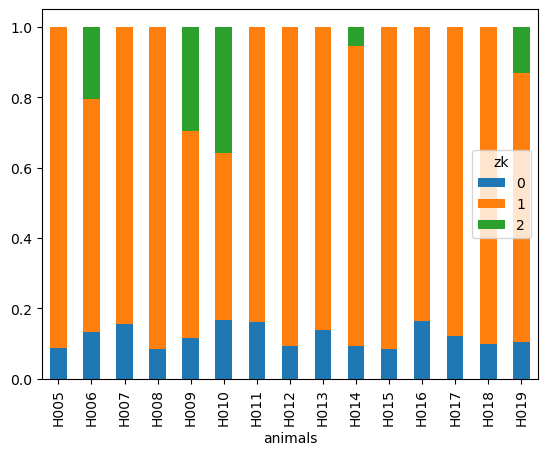

In [15]:
for i, dname in enumerate(dnames):
    K = Ks[i]

    data_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster'
    # results_dir = get_file_dir().parents[1] / "results" / "dmdm_global_fit" / dname

    # Load GLM-HMM results
    states_max_posterior, _, inpt_rt, _, session, _, _, mask, hmm_params \
        = load_global_glmhmm_result(K, model, data_dir, regularization)

    # Load raw data eids
    animal_list = load_animal_list(
        data_dir / 'data_by_animal' / 'animal_list.npz')
    animal_eid_dict = load_animal_eid_dict(
        data_dir / 'final_animal_eid_dict.json')

    # Create trial IDs
    trialnum_all = []
    for z, animal in enumerate(animal_list):
        sess_counter = 0
        for eid in animal_eid_dict[animal]:

            raw_session_id = eid.split('Subjects/')[1]
            # Get animal:
            animal = raw_session_id.split('/')[0]
            # Replace '/' with dash in session ID
            session_id = raw_session_id.replace('/', '-')

            trialnum = np.load(data_dir.parent / Path(eid) / '_dmdm_trials.trial.npy')[0]
            trialnum2 = [session_id + '-' + str(int(t)) for t in trialnum]
            trialnum_all.append(trialnum2)

    # Save outputs in json file
    rdict = defaultdict(list)
    for zk in range(K):
        b = np.where(states_max_posterior == zk)
        x = np.array(flatten_list(trialnum_all))[b]
        rdict[zk] = x.tolist()

    out_json = json.dumps(rdict)
    f = open(str(figure_dir / "state_session_trial_{}_K_{}_{}.json".format(dname, K, regularization)), "w")
    f.write(out_json)
    f.close()

    zkd = pd.DataFrame(
        {'zk': states_max_posterior,
        'trial_ids': flatten_list(trialnum_all)
        })

    zkd = pd.DataFrame(
        {'zk': states_max_posterior,
        'trial_ids': flatten_list(trialnum_all)
        })

    if dname == 'dataAllHumans':
        zkd['animals'] = 'H' + zkd.trial_ids.str.split('_').str[3]
        zkd['sessions'] = zkd.trial_ids.str.split('-').str[1]
    elif dname == 'dataAllMiceTraining':
        zkd['animals'] = zkd.trial_ids.str.split('-').str[0]
        zkd['sessions'] = zkd.trial_ids.str.split('-').str[1]

    zk_fraction_occupancy = zkd.groupby(['animals'])['zk'].value_counts(normalize=True).unstack().fillna(0)
    ax = zk_fraction_occupancy.plot.bar(stacked=True)

In [13]:
data_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster'
results_dir = get_file_dir().parents[1] / "results" / "dmdm_global_fit" / dname

# Load GLM-HMM results
states_max_posterior, _, inpt_rt, _, session, _, stim_onset, mask, hmm_params \
    = load_global_glmhmm_result(K, model, data_dir)

# Load raw data eids
animal_list = load_animal_list(
    data_dir / 'data_by_animal' / 'animal_list.npz')
animal_eid_dict = load_animal_eid_dict(
    data_dir / 'final_animal_eid_dict.json')

# Create trial IDs
trialnum_all = []
for z, animal in enumerate(animal_list):
    sess_counter = 0
    for eid in animal_eid_dict[animal]:

        raw_session_id = eid.split('Subjects/')[1]
        # Get animal:
        animal = raw_session_id.split('/')[0]
        # Replace '/' with dash in session ID
        session_id = raw_session_id.replace('/', '-')

        trialnum = np.load(data_dir.parent / Path(eid) / '_dmdm_trials.trial.npy')[0]
        trialnum2 = [session_id + '-' + str(int(t)) for t in trialnum]
        trialnum_all.append(trialnum2)

In [8]:
zkd = pd.DataFrame(
    {'zk': states_max_posterior,
     'trial_id': flatten_list(trialnum_all)
    })

if dname == 'dataAllHumans':
    zkd['animal'] = 'H' + zkd.trial_id.str.split('_').str[3]
    zkd['session'] = zkd.trial_id.str.split('-').str[1]
elif dname == 'dataAllMiceTraining':
    zkd['animal'] = zkd.trial_id.str.split('-').str[0]
    zkd['session'] = zkd.trial_id.str.split('-').str[1]

In [66]:
zk_fraction_occupancy = zkd.groupby(['animal'])['zk'].value_counts(normalize=True).unstack().fillna(0)

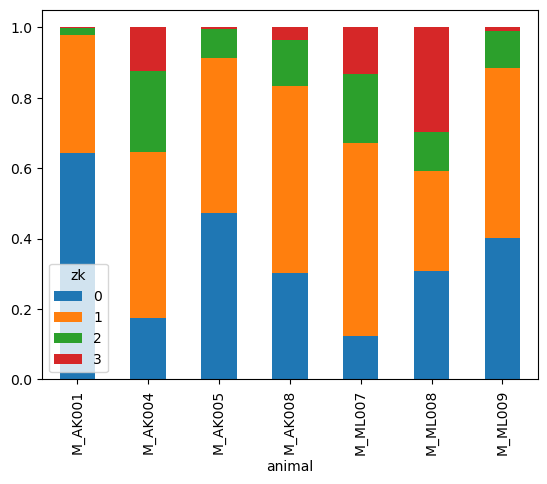

In [67]:
ax = zk_fraction_occupancy.plot.bar(stacked=True)

In [16]:
np.where(states_max_posterior == 0)[0]

array([     0,      1,      2, ..., 147842, 147843, 147844])

In [19]:
a = stim_onset[np.where(states_max_posterior == 0)[0],:]

In [20]:
len(a)

49198

In [21]:
sum(a<10)

array([29091])

In [22]:
b = stim_onset[np.where(states_max_posterior == 1)[0],:]

In [23]:
len(b)

63800

In [24]:
sum(b<10)

array([23198])

In [9]:
zkd

,zk,trial_id,animal,session
0,0,M_AK001-AK_001_s1_20201113_173033-1,M_AK001,AK_001_s1_20201113_173033
1,0,M_AK001-AK_001_s1_20201113_173033-2,M_AK001,AK_001_s1_20201113_173033
2,0,M_AK001-AK_001_s1_20201113_173033-3,M_AK001,AK_001_s1_20201113_173033
3,0,M_AK001-AK_001_s1_20201113_173033-4,M_AK001,AK_001_s1_20201113_173033
4,0,M_AK001-AK_001_s1_20201113_173033-5,M_AK001,AK_001_s1_20201113_173033
...,...,...,...,...
147926,1,M_ML009-ML_009_s1_20210720_164137-537,M_ML009,ML_009_s1_20210720_164137
147927,1,M_ML009-ML_009_s1_20210720_164137-538,M_ML009,ML_009_s1_20210720_164137
147928,1,M_ML009-ML_009_s1_20210720_164137-539,M_ML009,ML_009_s1_20210720_164137
147929,1,M_ML009-ML_009_s1_20210720_164137-540,M_ML009,ML_009_s1_20210720_164137


In [ ]:
zkd

In [69]:
def calc_switching_time(df: pd.DataFrame, normalize=True) -> pd.DataFrame:
    switch_across_sessions = []
    grouped_by_session = df.groupby(['session'])

    for sess, df_s in grouped_by_session:
        states_max_posterior = df_s['zk'].values
        diffs = np.diff(states_max_posterior)
        state_change_num = sum(np.abs(diffs) > 0)
        if normalize:
            state_change_num = state_change_num / len(states_max_posterior)

        switch_across_sessions.append(state_change_num)
    return switch_across_sessions

In [78]:
goo = calc_switching_time(zkd, normalize=False)

In [79]:
goo

[1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
# consider abort states_max_posterior nan

In [ ]:
master_y_inpt, master_y, master_session, master_rt, master_stim_onset